In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
from utils import load_cifar10, load_cifar100,load_tinyimagenet

In [70]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# load cifar10 data
trainloader, testloader = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# load dataloader for steal
stealloader,_ = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet()

# Train Model

In [7]:
from cifar_models import Net, Net_logit, AttackNet

## train original model

In [8]:
net = Net()

In [8]:
from utils import train_model_NLL

In [10]:
net_optim = optim.Adam(net.parameters(), lr=0.0001)

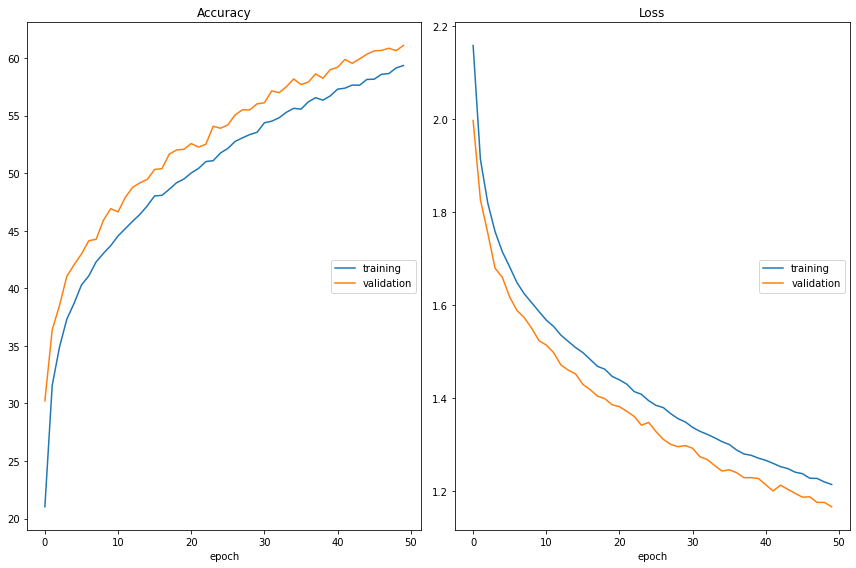

Accuracy
	training         	 (min:   21.030, max:   59.356, cur:   59.356)
	validation       	 (min:   30.230, max:   61.100, cur:   61.100)
Loss
	training         	 (min:    1.214, max:    2.158, cur:    1.214)
	validation       	 (min:    1.166, max:    1.997, cur:    1.166)


In [10]:
net, logs_net = train_model_NLL(net, trainloader, net_optim, device, epochs=50, 
                 test_loader = testloader, save_dir = "../results",save_model="cifar_orig_net.pth")

### load trained model

In [11]:
import os
net.load_state_dict(torch.load(os.path.join("../results","cifar_orig_net.pth")))

<All keys matched successfully>

### maximum score histogram

In [8]:
from utils import maxclass_hist, prediction_hist

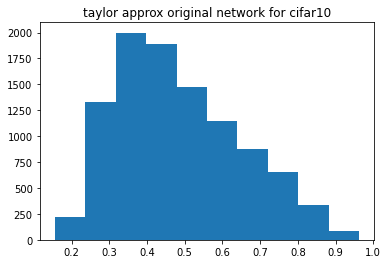

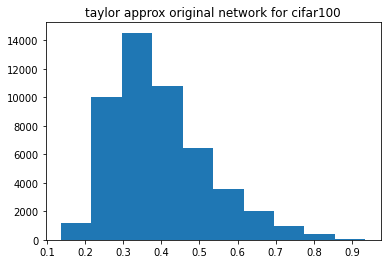

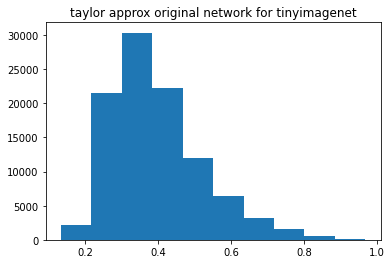

In [16]:
maxclass_hist(testloader, net, device, plt_title="taylor approx original network for cifar10")
maxclass_hist(stealloader, net, device, plt_title="taylor approx original network for cifar100")
maxclass_hist(outlier_loader, net, device, plt_title="taylor approx original network for tinyimagenet")

## Outlier Exposure

In [25]:
import copy
from utils import train_model_with_oe

In [14]:
net_oe = copy.deepcopy(net)

In [15]:
loss_in = nn.NLLLoss()
loss_out = nn.KLDivLoss(reduction='batchmean')
optimizer_oe = optim.Adam(net_oe.parameters(), lr=0.0001)

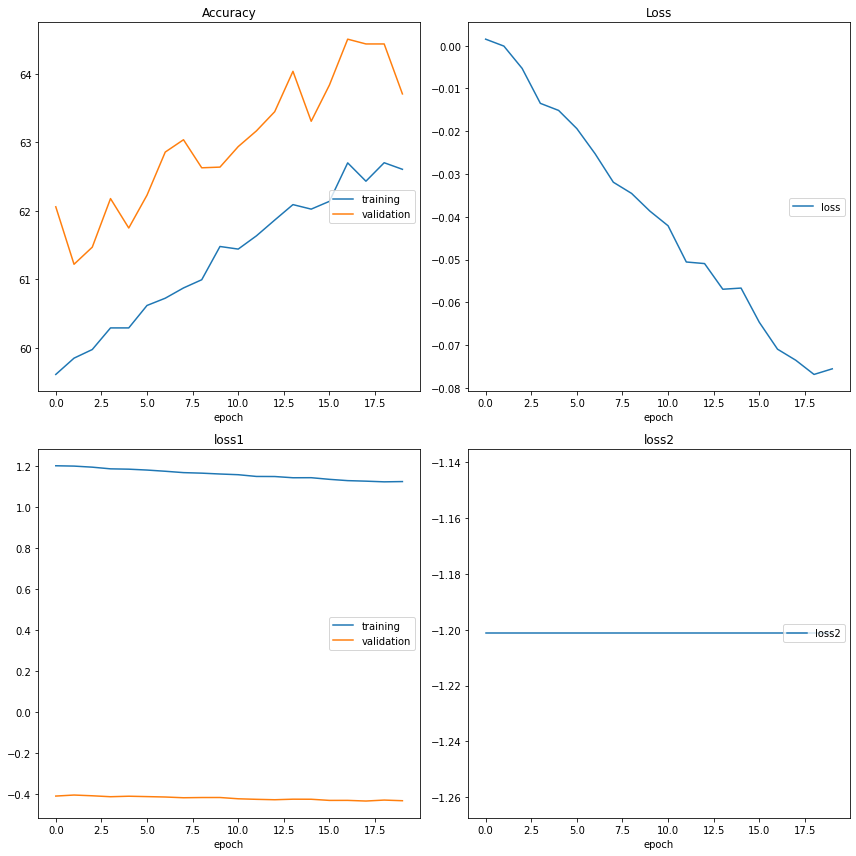

Accuracy
	training         	 (min:   59.610, max:   62.704, cur:   62.608)
	validation       	 (min:   61.220, max:   64.510, cur:   63.710)
Loss
	loss             	 (min:   -0.077, max:    0.002, cur:   -0.076)
loss1
	training         	 (min:    1.124, max:    1.203, cur:    1.126)
	validation       	 (min:   -0.432, max:   -0.403, cur:   -0.430)
loss2
	loss2            	 (min:   -1.201, max:   -1.201, cur:   -1.201)


In [45]:
net_oe, logs_oe = train_model_with_oe(net_oe, trainloader, outlier_loader, optimizer_oe, device, 
                          loss_in, loss_out, weight_out=0.5, epochs=20,pred_prob = True, test_loader = testloader,
                          save_dir = '../results', save_model="cifar_oe_net.pth")

### Load model

In [26]:
net_oe = Net()
net_oe.load_state_dict(torch.load(os.path.join("../results","cifar_oe_net.pth")))

<All keys matched successfully>

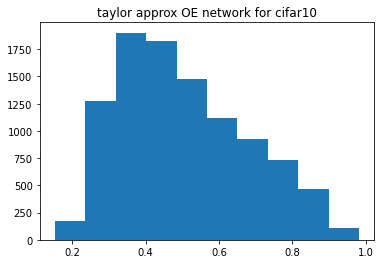

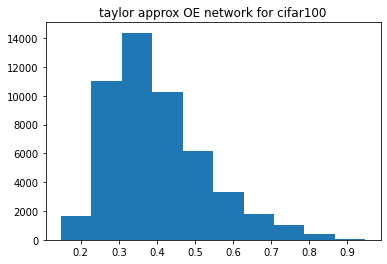

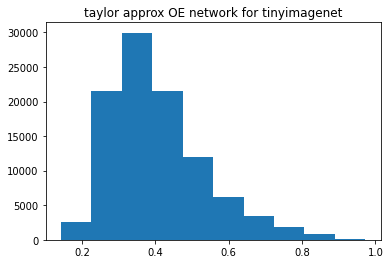

In [20]:
maxclass_hist(testloader, net_oe, device, plt_title="taylor approx OE network for cifar10")
maxclass_hist(stealloader, net_oe, device, plt_title="taylor approx OE network for cifar100")
maxclass_hist(outlier_loader, net_oe, device, plt_title="taylor approx OE network for tinyimagenet")

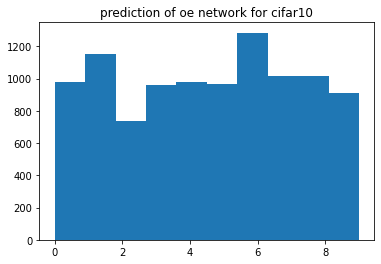

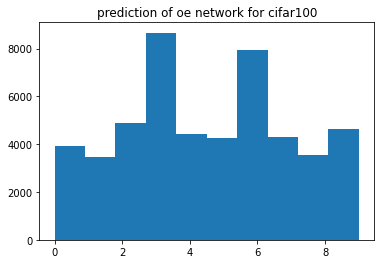

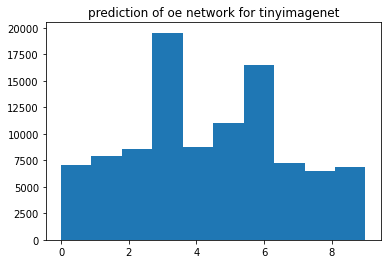

In [27]:
prediction_hist(testloader, net_oe, device, plt_title="prediction of oe network for cifar10")
prediction_hist(stealloader, net_oe, device, plt_title="prediction of oe network for cifar100")
prediction_hist(outlier_loader, net_oe, device, plt_title="prediction of oe network for tinyimagenet")

# Train Fake Net

## Taylor NLL + SWAE

In [11]:
fake_swd = Net()

In [18]:
from utils import train_swd_fakenet_NLL,make_st_loader

In [19]:
optim_swd = optim.Adam(fake_swd.parameters(),lr=0.0001)

In [20]:
st_loader = make_st_loader(net_oe, trainloader, device)

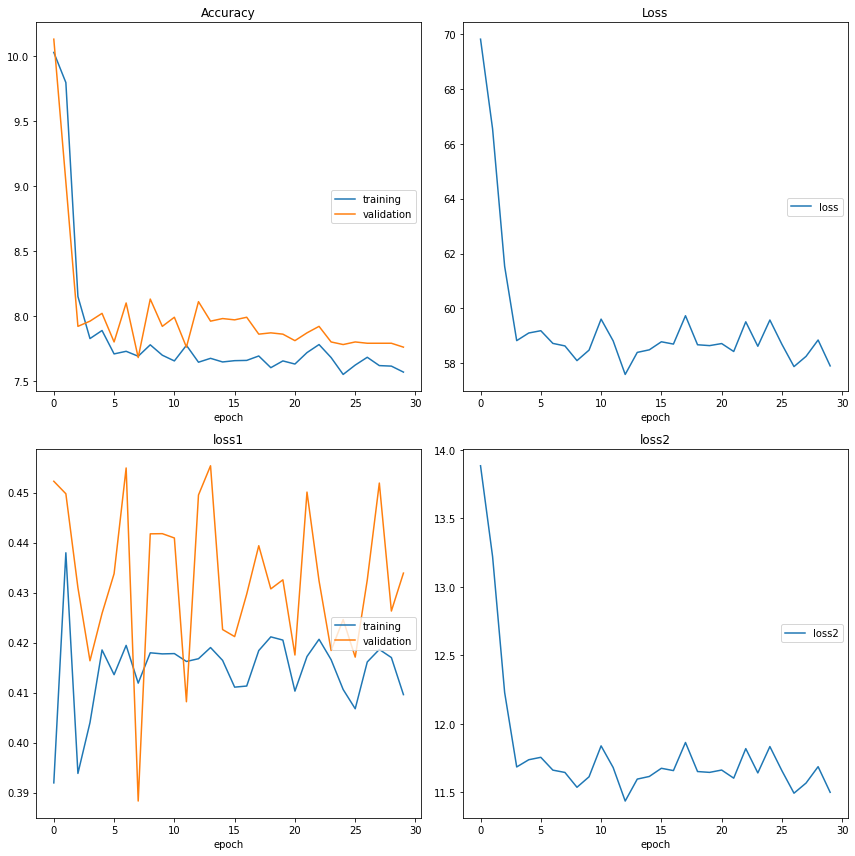

Accuracy
	training         	 (min:    7.550, max:   10.028, cur:    7.568)
	validation       	 (min:    7.680, max:   10.130, cur:    7.760)
Loss
	loss             	 (min:   57.595, max:   69.813, cur:   57.906)
loss1
	training         	 (min:    0.392, max:    0.438, cur:    0.410)
	validation       	 (min:    0.388, max:    0.455, cur:    0.434)
loss2
	loss2            	 (min:   11.436, max:   13.884, cur:   11.499)


In [21]:
fake_swae, fake_logs = train_swd_fakenet_NLL(fake_swd, trainloader, st_loader, optim_swd,device, epochs=30, 
                                             loss_weights=1., test_loader = testloader,
                                             save_dir = '../results',save_model="cifar_fake_taylor_swae.pth")

### load model

In [15]:
import os
fake_swd.load_state_dict(torch.load(os.path.join("../results","cifar_fake_taylor_swae.pth")))

<All keys matched successfully>

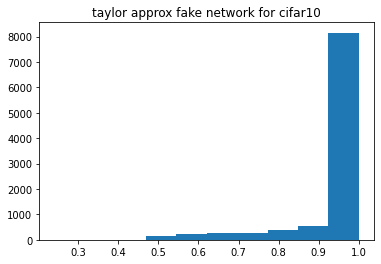

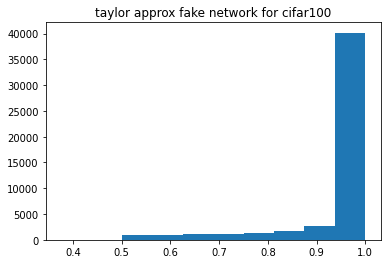

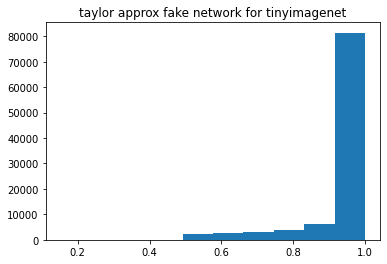

In [16]:
maxclass_hist(testloader, fake_swd, device, plt_title="taylor approx fake network for cifar10")
maxclass_hist(stealloader, fake_swd, device, plt_title="taylor approx fake network for cifar100")
maxclass_hist(outlier_loader, fake_swd, device, plt_title="taylor approx fake network for tinyimagenet")

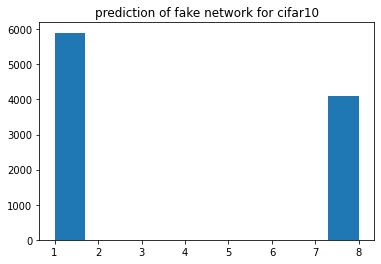

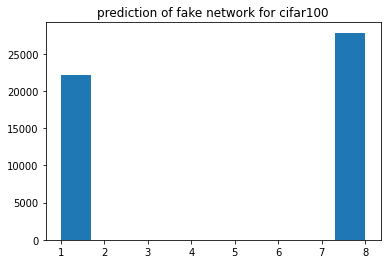

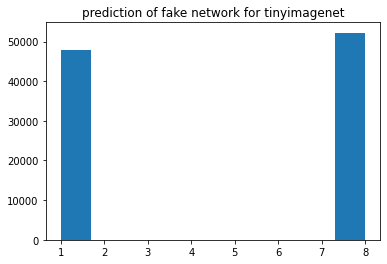

In [21]:
prediction_hist(testloader, fake_swd, device, plt_title="prediction of fake network for cifar10")
prediction_hist(stealloader, fake_swd, device, plt_title="prediction of fake network for cifar100")
prediction_hist(outlier_loader, fake_swd, device, plt_title="prediction of fake network for tinyimagenet")

## Taylor NLL with random label

In [39]:
from utils import make_randomlabel, train_model_NLL

In [37]:
net_random = Net()

In [55]:
random_loader = make_randomlabel(trainloader)
net_optim = optim.Adam(net_random.parameters(), lr=0.0001)

/tmp/ipykernel_901/3915072172.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  randset = torch.utils.data.TensorDataset(torch.tensor(train_all[0]),randlabel.type(torch.LongTensor))


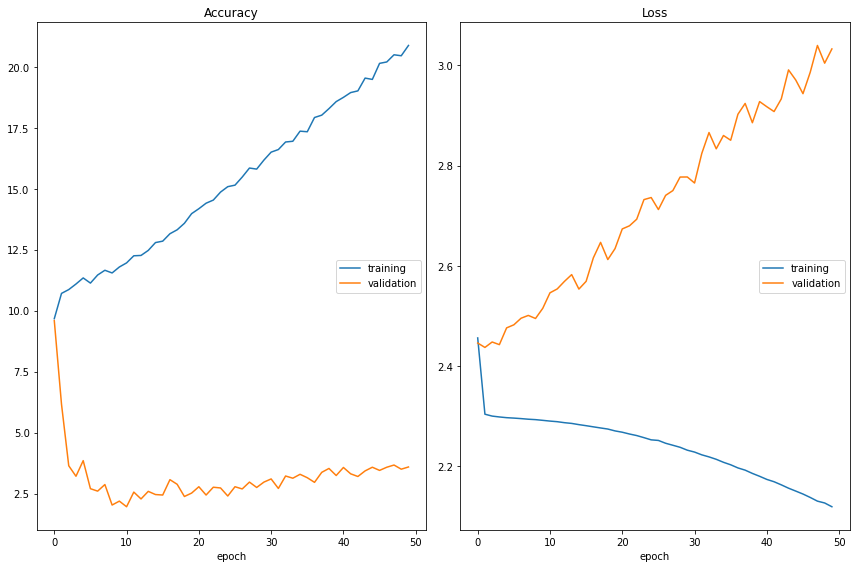

Accuracy
	training         	 (min:    9.670, max:   20.874, cur:   20.874)
	validation       	 (min:    1.960, max:    9.590, cur:    3.590)
Loss
	training         	 (min:    2.119, max:    2.456, cur:    2.119)
	validation       	 (min:    2.437, max:    3.040, cur:    3.033)


In [59]:
net_random, logs_net = train_model_NLL(net_random, random_loader, net_optim, device, epochs=50, 
                 test_loader = testloader, save_dir = "../results",save_model="cifar_fake_random_net.pth")

### load model

In [60]:
import os
net_random.load_state_dict(torch.load(os.path.join("../results","cifar_fake_random_net.pth")))

<All keys matched successfully>

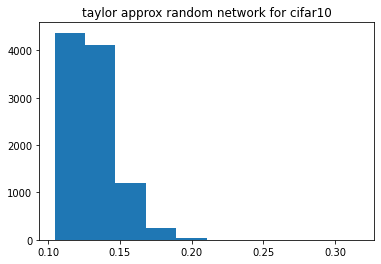

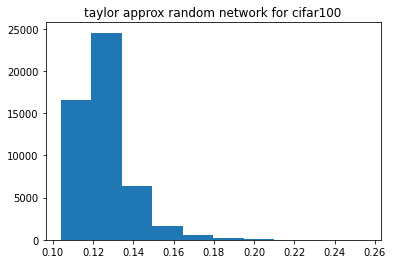

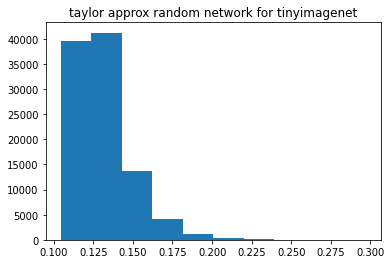

In [61]:
maxclass_hist(testloader, net_random, device, plt_title="taylor approx random network for cifar10")
maxclass_hist(stealloader, net_random, device, plt_title="taylor approx random network for cifar100")
maxclass_hist(outlier_loader, net_random, device, plt_title="taylor approx random network for tinyimagenet")

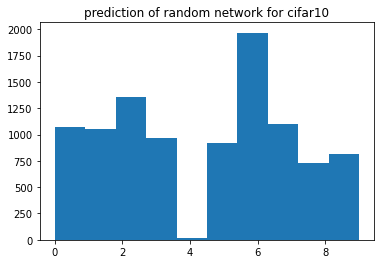

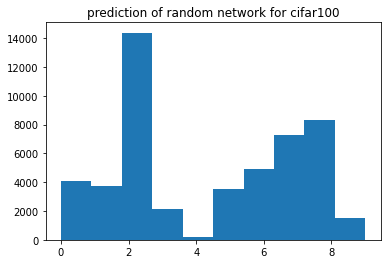

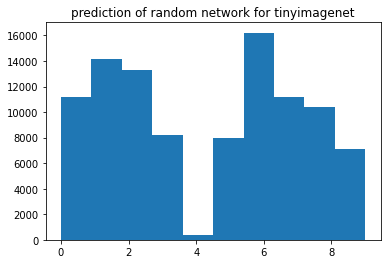

In [62]:
prediction_hist(testloader, net_random, device, plt_title="prediction of random network for cifar10")
prediction_hist(stealloader, net_random, device, plt_title="prediction of random network for cifar100")
prediction_hist(outlier_loader, net_random, device, plt_title="prediction of random network for tinyimagenet")

In [69]:
list(list(net_random.modules())[-1].parameters())

[Parameter containing:
 tensor([[ 0.0093, -0.0626, -0.0667,  ...,  0.0425, -0.0230, -0.0428],
         [ 0.0714,  0.0301,  0.0856,  ...,  0.0061, -0.0396,  0.0144],
         [-0.0308, -0.0557, -0.0021,  ..., -0.0338,  0.0233, -0.0032],
         ...,
         [ 0.0412,  0.0623,  0.0350,  ..., -0.0423,  0.0275, -0.0445],
         [ 0.0031, -0.0142, -0.0896,  ..., -0.0541,  0.0642,  0.0845],
         [ 0.0299, -0.0721,  0.0574,  ...,  0.0177,  0.0376, -0.0158]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0208, -0.0891,  0.1132, -0.0043,  0.0100, -0.0988, -0.0014, -0.0559,
          0.0514, -0.0732], requires_grad=True)]